# Foreign Exchange Rate Simulation and Hedging of FX Risk

In [1]:
import numpy as np
import numpy_financial as npf
import pandas as pd
import matplotlib.pyplot as plt
import datetime

np.random.seed(0)

### Import Cashflows

In [2]:
cashflows = pd.read_excel("Copy of Quantitative Analyst Case Study Sept 2021 - Cashflow Model.xlsx")
cashflows['Date'] = pd.to_datetime(cashflows['Date'])
cashflows.head(10)


,Date,Fund,Cashflow Type,Cashflow Amount (in Local Asset Currecny),Local Asset Currency,Fund Currency,Base Case IRR
0,2021-08-31,Validus V,Equity,-100000000,GBP,USD,0.149914
1,2022-08-31,Validus V,Proceeds,15000000,GBP,USD,NaN
2,2023-08-31,Validus V,Proceeds,15000000,GBP,USD,NaN
3,2024-08-31,Validus V,Proceeds,15000000,GBP,USD,NaN
4,2025-08-31,Validus V,Proceeds,15000000,GBP,USD,NaN
5,2026-08-31,Validus V,Proceeds,115000000,GBP,USD,NaN


### GBM

In [3]:
FX_start = 1.37625 # Starting exchange rate
date_start = datetime.datetime(2021, 8, 21)
date_expiry = datetime.datetime(2026, 8, 31)
strike_price = 1.37625
no_days = (date_expiry - date_start).days
W_t = np.random.randn(1000, no_days)
simulated_paths = np.zeros((1000, no_days + 1))
mu = 0
sigma = 0.093/np.sqrt(365) # Daily volatility

dSS = sigma*W_t # GBM
simulated_paths[:, 0] = FX_start
simulated_paths[:, 1:] = FX_start * np.exp(np.cumsum(dSS, axis=1))
simulated_paths = pd.DataFrame(simulated_paths.T)
dates = pd.date_range(start=date_start, end=date_expiry)
print(dates)
simulated_paths['dates'] = dates
simulated_paths = simulated_paths.set_index(['dates'])
simulated_paths.head()

DatetimeIndex(['2021-08-21', '2021-08-22', '2021-08-23', '2021-08-24',
               '2021-08-25', '2021-08-26', '2021-08-27', '2021-08-28',
               '2021-08-29', '2021-08-30',
               ...
               '2026-08-22', '2026-08-23', '2026-08-24', '2026-08-25',
               '2026-08-26', '2026-08-27', '2026-08-28', '2026-08-29',
               '2026-08-30', '2026-08-31'],
              dtype='datetime64[ns]', length=1837, freq='D')


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
dates,,,,,,,,,,,,,,,,,,,,,
2021-08-21,1.376250,1.376250,1.376250,1.376250,1.376250,1.376250,1.376250,1.376250,1.376250,1.376250,...,1.376250,1.376250,1.376250,1.376250,1.376250,1.376250,1.376250,1.376250,1.376250,1.376250
2021-08-22,1.388119,1.379861,1.371168,1.379198,1.380482,1.378845,1.379769,1.372237,1.376519,1.390214,...,1.380767,1.375526,1.386116,1.367323,1.365551,1.367235,1.368469,1.381283,1.390173,1.373703
2021-08-23,1.390825,1.378905,1.368019,1.375756,1.382614,1.370907,1.380608,1.367905,1.371182,1.393021,...,1.378027,1.376564,1.399146,1.358213,1.365532,1.360532,1.347942,1.382238,1.386092,1.373494
2021-08-24,1.397468,1.377561,1.368743,1.375509,1.382679,1.362887,1.396053,1.380349,1.369861,1.389696,...,1.380662,1.370724,1.401332,1.351852,1.367929,1.353479,1.338074,1.390405,1.378829,1.371674
2021-08-25,1.412795,1.366114,1.373203,1.383797,1.388458,1.361870,1.393491,1.378327,1.372279,1.395607,...,1.385897,1.379705,1.396594,1.346092,1.373959,1.359903,1.333092,1.387544,1.379927,1.378509


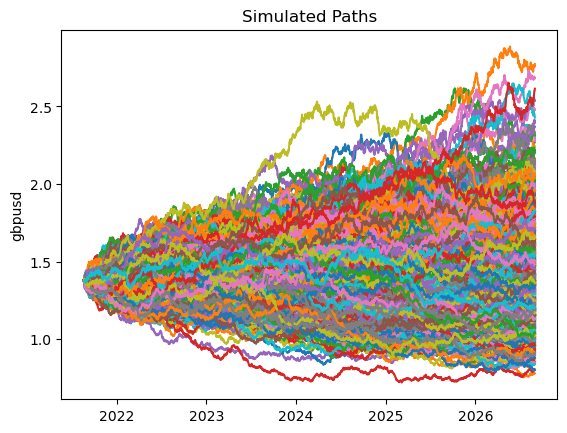

In [4]:
plt.plot(simulated_paths)
plt.title('Simulated Paths')
plt.ylabel('gbpusd')
plt.show()

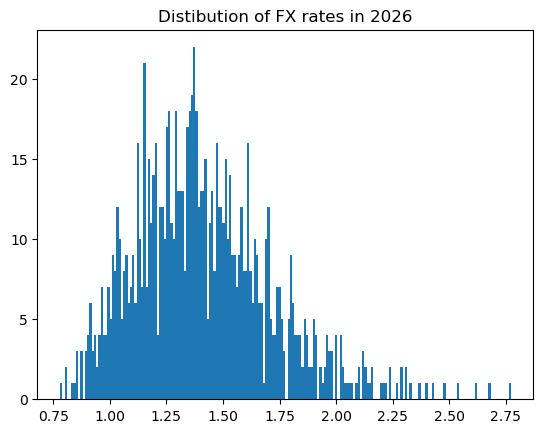

In [5]:
plt.hist(simulated_paths.iloc[-1], bins=200)
plt.title('Distibution of FX rates in 2026')
plt.show()

### IRR unhedged portfolio

In [6]:
cashflow_gbp = cashflows['Cashflow Amount (in Local Asset Currecny)']
cashflow_dates = cashflows['Date']
irrs = []
fx_rates = simulated_paths.loc[cashflow_dates].to_numpy().T
for fx in fx_rates:
    cashflows_usd = fx*cashflow_gbp
    irrs.append(npf.irr(cashflows_usd))

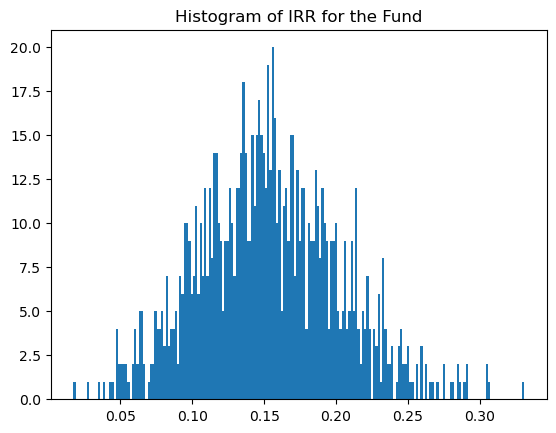

In [7]:
plt.hist(irrs, bins=200)
plt.title('Histogram of IRR for the Fund')
plt.show()

In [8]:
print('Percentiles:')
print('95%: {}'.format(np.percentile(irrs, 95)))
print('50%: {}'.format(np.percentile(irrs, 50)))
print('5%: {}'.format(np.percentile(irrs, 5)))

Percentiles:
95%: 0.23460097209871833
50%: 0.15120716791278332
5%: 0.07593339547213769


### Put Option

In [9]:
# Calculate the put value by averaging the final payoffs and multiplying by contract size.
final_payoff = strike_price - simulated_paths.loc[date_expiry]
final_payoff = np.clip(final_payoff, 0, np.max(final_payoff))
put_value = np.average(final_payoff)


contract_size = 100000000/1.37625
put_value = contract_size * put_value
print('Put Value: {}'.format(put_value))

Put Value: 7155351.927672517


In [10]:
hedged_cashflow = cashflows.copy()

In [11]:
cashflow_gbp = hedged_cashflow['Cashflow Amount (in Local Asset Currecny)'].to_numpy()
cashflow_dates = hedged_cashflow['Date'].to_numpy()
irrs_hedged = []
fx_rates = simulated_paths.loc[cashflow_dates].to_numpy().T
for idx,fx in enumerate(fx_rates):
    cashflows_usd = np.zeros(len(fx))
    
    cashflows_usd[0] = fx[0]*cashflow_gbp[0] - put_value
    
    cashflows_usd[-1] = fx[-1]*cashflow_gbp[-1] + contract_size * np.clip(strike_price - fx[-1], 0, np.max(fx))
    cashflows_usd[1:-1] = fx[1:-1]*cashflow_gbp[1:-1]
    irrs_hedged.append(npf.irr(cashflows_usd))
    

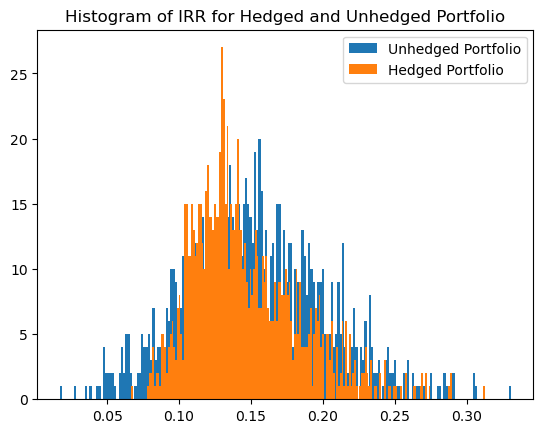

In [12]:
plt.hist(irrs, bins=200, label='Unhedged Portfolio')
plt.hist(irrs_hedged, bins=200, label='Hedged Portfolio')
plt.title('Histogram of IRR for Hedged and Unhedged Portfolio')
plt.legend()
plt.show()

The put option reduces the average of the IRR as well as the upside, however, it reduces the risk with the IRR estimated to not go below 0.06. The distribution is more concentrated around the new average.